# BEE 4750 Homework 4: Generating Capacity Expansion

**Name**:

**ID**:

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [38]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/hw04-teaganraesmith`


In [39]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 100 Points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

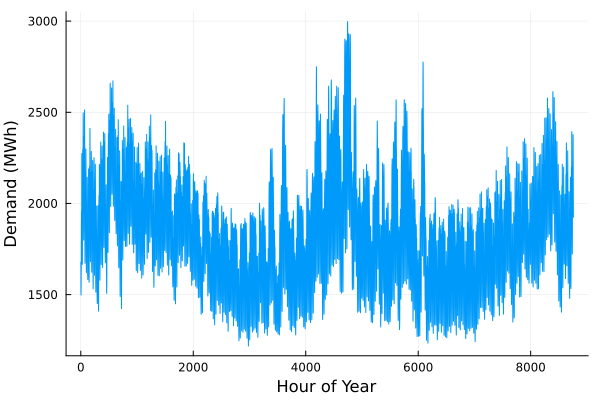

In [40]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data. This data includes fixed costs (\$/MW
installed), variable costs (\$/MWh generated), and CO<sub>2</sub>
emissions intensity (tCO<sub>2</sub>/MWh generated).

In [41]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

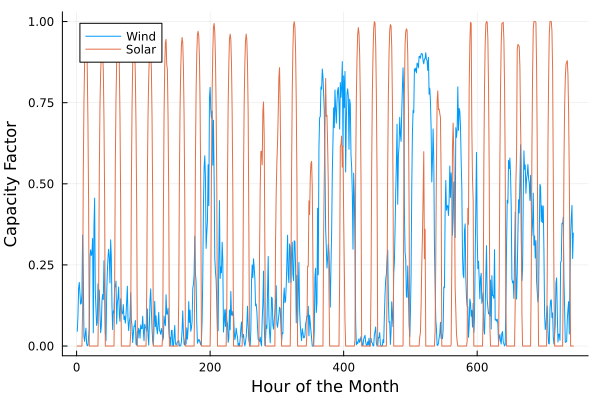

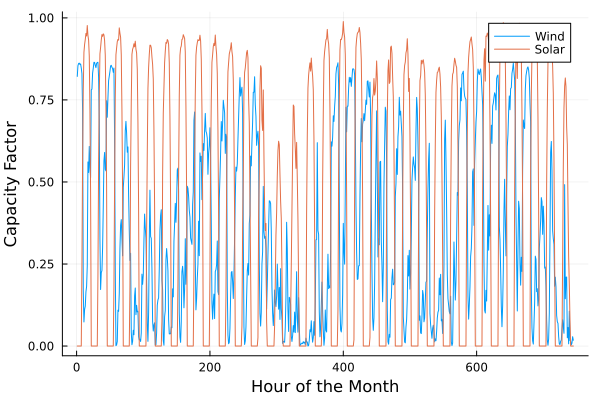

In [42]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley, NY, which currently has no existing electrical
generation infrastructure. The utility can build any of the following
plant types: geothermal, coal, natural gas combined cycle gas turbine
(CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$1000/MWh.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision!

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

### Problem 1 (22 points)

Your first task is to find a capacity expansion plan which minimizes
total costs of investment and operation.

#### Problem 1.1 (2 points)

Identify and define the decision variables for the problem. Make sure to
include units.

The decision variables are:
$$x(g) \text{: Installed capacity (MW) from each generator type g∈G}$$
$$y(g,t) \text{: Production (MW) from each generator in hour t∈T }$$
$$NSE(t) \text{: Non-served energy (MWh) in hour t∈T}$$

#### Problem 1.2 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s) and define any
additional required notation beyond that introduced in Problem 1.1.

The objective function is to minimize cost for the production of energy.

$$\text{Cost=investment cost+operating cost}$$
$$\text{Cost=}\sum_{g∈G}\text{FixedCost}(g)*x(g)+ \sum_{g∈G}\sum_{t∈T}\text{VarCost}(g)*y(g,t)+\sum_{t∈T}\text{NSE Cost}*NSE(t)$$

Where the FixedCost and VarCost are given in the table above, and the NSE Cost is given as $1000/MWh for any generator type.

#### Problem 1.3 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

The first constraint is that all decision variables must be non-negative. 

$$x(g)\ge 0$$
$$y(g,t)\ge 0$$
$$NSE(t)\ge 0$$

The next constraint is that each generator cannot produce above its capacity. Where c(g,t) is the capacity factor in a time period t for generator type g.

$$y(g,t)\le x(g)*c(g,t)$$

The sum of generated energy and non-served energy must equal demand (d(t)).

$$\sum_{g∈G}y(g,t)+NSE(t)=d(t)$$

Were all t∈T and g∈G.

#### Problem 1.4 (3 points)

Implement your optimization problem in `JuMP`.

In [43]:
G=1:nrow(gens) #Number of generators
T=1:nrow(demand) #Number of time periods

#Makingthe capacity factor matrix
cap_fact=ones(T[end],G[end]-2) #Ones to start and manipulate later 
#Subtracting 2 to erase wind and solar which are dependent on hours in a month
cap_fact[:,1].=0.85 #Geothermal capacity factor
cap_wind=cap_factor[!,:Wind] #Selecting wind and solar data
#Exclamation does the same job as colon for all rows selection (but with strings)
cap_solar=cap_factor[!,:Solar]
capacity=hcat(cap_fact, cap_wind, cap_solar) #Appending all capacity factors

using JuMP
using HiGHS
model=Model(HiGHS.Optimizer)

#Defining Variables
@variable(model, x[g in G]>=0)
@variable(model, y[g in G, t in T]>=0)
@variable(model, NSE[t in T]>=0)

nseCost=1000 #Given Constant in Dollars
FixedCost=gens[:,:FixedCost] #Putting given fixed cost from data into an array
VarCost=gens[:,:VarCost] #Putting given variable cost from data into an array

#Defining Objective 
@objective(model, Min, sum(FixedCost.*x)+sum(VarCost.*[sum(y[g,:]) for g in G])+nseCost*sum(NSE))

#Defining Constraints
@constraint(model, capacity[g in G, t in T], y[g,t]<=x[g]*capacity[t,g])
@constraint(model, dem[t in T], sum(y[:,t])+NSE[t]==demand.Demand[t]);

#### Problem 1.5 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What will the total cost be? How much energy
will be non-served?

In [44]:
optimize!(model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
56856 rows, 56862 cols, 153048 nonzeros
56856 rows, 56862 cols, 153048 nonzeros
Presolve : Reductions: rows 56856(-4464); columns 56862(-4464); elements 153048(-8928)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.52383e+06) 0s
      41818     6.4455540055e+08 Pr: 0(0); Du: 0(3.01981e-14) 4s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 41818
Objective value     :  6.4455540055e+08
HiGHS run time      :          4.54


In [45]:
prob1_built_cap=value.(x.data) #Defining this variable for problem 2 comparison
print("The quantity of Geothermal, Coal, CCGT, CT, Wind, Solar to build respectively are: ", value.(x.data), " MW")

The quantity of Geothermal, Coal, CCGT, CT, Wind, Solar to build respectively are: [0.0, 0.0, 1644.2566680139157, 687.0938020115696, 534.5117098500876, 1944.5521514062018] MW

In [46]:
print("The quantity of energy Non-Served is: ", sum(value.(NSE).data),  " MWh")

The quantity of energy Non-Served is: 5966.0484237646615 MWh

In [47]:
print("Total Cost is: ", objective_value(model), " dollars")

Total Cost is: 6.445554005499631e8 dollars

#### Problem 1.6 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 1.5? Do these results make sense given the generator data?

In [48]:
ann_gen=[sum(value.(y[g,:]).data) for g in G]
fraction_produce=ann_gen./sum(ann_gen)
print("The Fraction of Annual Generation of Geothermal, Coal, CCGT, CT, Wind, Solar respectively are: ", fraction_produce)

The Fraction of Annual Generation of Geothermal, Coal, CCGT, CT, Wind, Solar respectively are: [0.0, 0.0, 0.5223218098555165, 0.02743264415112524, 0.09576108182134967, 0.35448446417200863]

In [49]:
built_cap=value.(x.data)
fraction_built1=built_cap./sum(built_cap)
print("The Fraction of Built Capacity Geothermal, Coal, CCGT, CT, Wind, Solar respectively has is: ", fraction_built1)

The Fraction of Built Capacity Geothermal, Coal, CCGT, CT, Wind, Solar respectively has is: [0.0, 0.0, 0.3418118595983373, 0.14283464057211215, 0.11111552416061062, 0.4042379756689399]

The built capacity and annual generation percentage for each type is the same (at zero) for geothermal and coal. For CCGT, the annual generation is about .2 greater than the built capacity. For CT, the built capacity is about .12 more than the annual generation. For both wind and solar, the built capacity approximately equal to the annual generation percentage. It makes sense because fixed cost is the highest for coal and geothermal, meaning it would be least likely to be built relative to how much it produces in energy. All of the other generator options have a much lower fixed cost. Solar has the greatest built capacity because it has no variable cost so it produces energy with low cost so more of it will be built. CCGT has the highest annual generation because of its efficiency as a power source and the fact that it has a low fixed/variable cost so more of it was built.

### Problem 2 (18 points)

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

#### Problem 2.1 (3 points)

What changes are needed to your linear program from Problem 1?
Re-formulate the problem and report it in standard form.

The emissions must be below 1.5 MtCO2/yr which corresponds to 1500000 tCO2/yr. Emissions are given in a table based on generator type in the problem statement.

$$\sum_{g∈G}(Emissions*\sum_{g∈G}(y(g)))\le 1500000$$

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [50]:
Emissions=gens[:,:Emissions]
@constraint(model, CO2, sum(Emissions.*[sum(y[g,:]) for g in G])<=1500000);

#### Problem 2.3 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What is different from your plan from Problem
1? Do these changes make sense?

In [51]:
optimize!(model)

Solving LP without presolve or with basis
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     6.4458523850e+08 Pr: 1(605433); Du: 0(2.50664e-08) 4s
       1246     6.6076367740e+08 Pr: 3294(1.82456e+06); Du: 0(7.23809e-08) 10s
       3079     6.6495329671e+08 Pr: 1011(2.67715e+06); Du: 0(7.23809e-08) 16s
       4894     6.6495404925e+08 Pr: 1059(2.69503e+06); Du: 0(7.23809e-08) 21s
       6958     6.6495506463e+08 Pr: 1066(2.71108e+06); Du: 0(7.23809e-08) 26s
       8458     6.7009090842e+08 Pr: 3044(1.12943e+06); Du: 0(2.50664e-08) 32s
       9665     6.7993098931e+08 Pr: 9615(1.7468e+07); Du: 0(1.02824e-07) 37s
      10918     6.9078882434e+08 Pr: 4489(1.1852e+06); Du: 0(1.02824e-07) 42s
      12634     6.9606141165e+08 Pr: 3301(1.2353e+06); Du: 0(1.02824e-07) 47s
      14269     7.1308901859e+08 Pr: 2434(416603); Du: 0(1.02824e-07) 53s
      16034     7.3147722860e+08 Pr: 1811(275696); Du: 0(1.02824e-07) 58s
      17635   

In [52]:
print("The quantity of Geothermal, Coal, CCGT, CT, Wind, Solar to build respectively are: ", value.(x.data), " MW")

The quantity of Geothermal, Coal, CCGT, CT, Wind, Solar to build respectively are: [270.99128000015827, 0.0, 1519.827914540965, 452.6760769023945, 2585.842607325182, 2118.579249996611] MW

The differences are that Geothermal went from 0 to 270, Coal went from 0 to 0, CCGT went from 1644 to 1519, CT went from 687 to 452, Wind went from 534 to 2585, and Solar went from 1944 to 2118. Solar, wind, and geothermal all increased. These are the renewable sources of energy which would produce the least amount of emissions. While the combined cycle gas turbine and combustion turbine decreased as they release more emissions through natural gas. This makes sense because there was a limit set on emissions so the model had to optimize around that constraint.

#### Problem 2.4 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 2.3? What are the differences between these results and your
plan from Problem 1?

In [53]:
ann_gen_CO2=[sum(value.(y[g,:]).data) for g in G]
fraction_CO2=ann_gen_CO2./sum(ann_gen_CO2)
print("The Fraction of Annual Generation of Geothermal, Coal, CCGT, CT, Wind, Solar respectively are: ", fraction_CO2)

The Fraction of Annual Generation of Geothermal, Coal, CCGT, CT, Wind, Solar respectively are: [0.06302117837676185, 0.0, 0.20382488507983393, 0.00736233665208312, 0.4044505046152248, 0.32134109527609633]

In [54]:
built_cap=value.(x.data)
fraction_built=built_cap./sum(built_cap)
print("The Fraction of Built Capacity Geothermal, Coal, CCGT, CT, Wind, Solar respectively has is: ", fraction_built)

The Fraction of Built Capacity Geothermal, Coal, CCGT, CT, Wind, Solar respectively has is: [0.0390032401046089, 0.0, 0.218745832221958, 0.06515277435135988, 0.3721752230779274, 0.30492293024414585]

As you can see, the values are fairly similar. The annual generation that they each produce is relatively similar to the fraction of the total built capacity that they account for. 

The fraction of annual generation (from problem 1 to problem 2) went from 0.0 to 0.06 for geothermal, 0.0 to 0.0 for Coal, 0.52 to 0.20 for CCGT, 0.027 to 0.007 for CT, 0.0956 to 0.404 for Wind, and 0.35 to 0.32 for Solar. This means that geothermal and wind went up, while CCGT, CT went down, and solar remained about the same. This indicates that the lower emission regulations have meant that the generation of renewable energy increased while non-renewables went down to accomodate for this town.



In [55]:
frac_built_cap_prob1=prob1_built_cap./sum(prob1_built_cap) #Finding the fraction built from problem 1
print("The Fraction of Built Capacity Geothermal, Coal, CCGT, CT, Wind, Solar respectively has is: ", frac_built_cap_prob1)

The Fraction of Built Capacity Geothermal, Coal, CCGT, CT, Wind, Solar respectively has is: [0.0, 0.0, 0.3418118595983373, 0.14283464057211215, 0.11111552416061062, 0.4042379756689399]

The fraction of the built capacity (from problem 1 to problem 2) went from 0.0 to 0.039 for Geothermal, 0.0 to 0.0 for Coal, 0.342 to 0.219 for CCGT, 0.143 to 0.065 for CT, 0.111 to 0.372 for wind, and 0.404 to 0.305 for solar. This means that geothermal and wind both went up while CCGT, CT, and solar went down. The built capacity needed to meet the new emissions standards while still providing the demanded energy went up for the renewables in this case, and once again down for the non-renewables. It is interesting that solar also went down, but perhaps it could be that solar provides less energy than geothermal or wind based on the hourly capacity or costs more to build, so to meet all of those constraints and keep emissions low, it had to also be reduced. 

#### Problem 2.5 (2 points)

What would the value to the utility be of allowing it to emit an
additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

In [56]:
shadow_price(CO2)

-183.86131591226533

The reduction of price for each ton of CO2 allowed to be emitted is 183.86 dollars. This means that for 1000 tons of CO2 the total cost to install this would be 183,860 dollars less than before. Additionally for 5000 tons of CO2, this would be 919,300 less in total cost. 

## References

List any external references consulted, including classmates.

I consulted with Gabriela the TA and gave assistance to Emma Rose Connolly and Mia Rusk.